# Naive Bayes

Spring 2018 - Profs. Foster Provost and Josh Attenberg

Teaching Assistant: Apostolos Filippas

***



Read in some packages.

In [1]:
# Import the libraries we will be using
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

np.random.seed(36)

import sys
sys.path.append("..")

from ds_utils.spam_data import load_spam_ham

### Data
For this class we use the spam dataset described previously. 

In [2]:
spam_df = load_spam_ham()
spam_df.head(2)

,text,spam
0,Hi...I have to use R to find out the 90% confi...,ham
1,"Francesco Poli wrote:> On Sun, 15 Apr 2007 21:...",ham


In [3]:
def is_spam(label):
    return 1 if label == "spam" else 0

labels = spam_df["spam"].apply(is_spam)
labels.value_counts()

0    4864
1    3246
Name: spam, dtype: int64

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X_train_txt, X_test_txt, y_train, y_test = train_test_split(spam_df["text"], labels, train_size=0.75, test_size=0.25)
    
vectorizer = CountVectorizer(binary=True)
X_train = vectorizer.fit_transform(X_train_txt)
X_test = vectorizer.transform(X_test_txt)

### Modeling with another technique: Naive Bayes

So far we have been exposed to tree classifiers and logistic regression in class. We have also some other models in the homework. Now, it's time for another popular modeling technique of supervised learning (especially in text classification): the Naive Bayes (NB) classifier. In particular, we are using a Bernoulli Naive Bayes (BNB) for our binary classification. (Bernoulli NB is the model described in the book; there are other versions of NB, see below.)

As described in your text, the Naive Bayes model is a **probabilistic approach which assumes conditional independence between features** (in this case, each word is a feature, the conditioning is on the true class). It assigns class labels (e.g. spam = 1 or spam = 0). In other words, Naive Bayes models the probabilities of the presence of each _word_, given that we have a spam email, and given that we have a non-spam email.  Then it combines them using Bayes Theorem (again, as described in the book).

Using this model in sklearn works just the same as the others we've seen ([More details here..](http://scikit-learn.org/stable/modules/naive_bayes.html))

- Choose the model
- Fit the model (Train)
- Predict with the model (Train or Test or Use data)

In [5]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_auc_score

model = BernoulliNB()
model.fit(X_train, y_train)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [6]:
print ("AUC on the count TRAIN data = %.3f" % roc_auc_score(model.predict(X_train), y_train))
print ("AUC on the count TEST data = %.3f" % roc_auc_score(model.predict(X_test), y_test))

AUC on the count TRAIN data = 0.981
AUC on the count TEST data = 0.976


The past few weeks we have seen that many of the models we are using have different complexity control parameters that can be tweaked. In naive Bayes, the parameter that is typically tuned is the Laplace smoothing value **`alpha`**.

Also, there are other versions of naive Bayes:

1. **Multinomial naive Bayes (MNB):** This model handles count features and not just binary features. Sometimes MNB is used with binary presence/absence variables anyway (like word presence), even though that violates the model assumptions, because in practice it works well anyway.
2. **Gaussian Naive Bayes (GNB):** This model considers likelihood of the features as Gaussian--and thus we can use it for continuous features.  Sometimes GNB and Bernoulli NB are combined when one has features of mixed types.  

In [32]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve

def build_curve(X_train_txt, X_test_txt, y_train, y_test, featurizer, model, training_sample=1.0):
    to_get = training_sample*len(X_train_txt)

    X_train = featurizer.fit_transform(X_train_txt[:int(to_get)]).toarray()
    X_test = featurizer.transform(X_test_txt).toarray()
    
    model.fit(X_train, y_train[:int(to_get)])
    return roc_curve(y_test, model.predict_proba(X_test)[:,1])

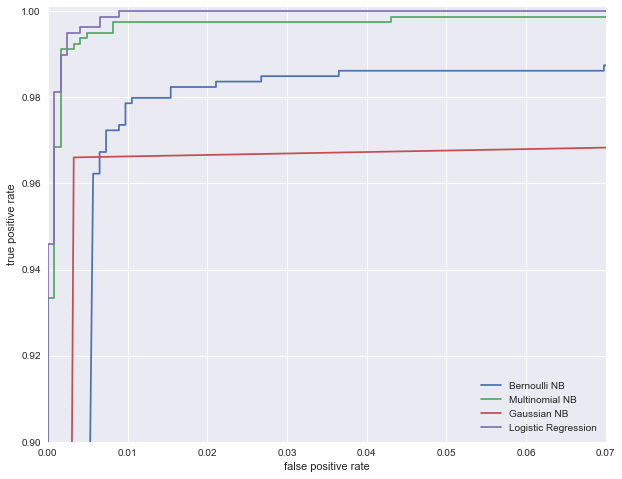

In [25]:

bern_fpr, bern_tpr, thresholds = build_curve(X_train_txt, X_test_txt, y_train, y_test, CountVectorizer(binary=True), BernoulliNB())

multi_fpr, multi_tpr, thresholds = build_curve(X_train_txt, X_test_txt, y_train, y_test, CountVectorizer(binary=False), MultinomialNB())

gauss_fpr, gauss_tpr, thresholds = build_curve(X_train_txt, X_test_txt, y_train, y_test, TfidfVectorizer(), GaussianNB())

lr_fpr, lr_tpr, thresholds = build_curve(X_train_txt, X_test_txt, y_train, y_test, TfidfVectorizer(), LogisticRegression())


plt.plot(bern_fpr, bern_tpr, label="Bernoulli NB")
plt.plot(multi_fpr, multi_tpr, label="Multinomial NB")
plt.plot(gauss_fpr, gauss_tpr, label="Gaussian NB")
plt.plot(lr_fpr, lr_tpr, label="Logistic Regression")

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="lower right")

plt.xlim([0, .07])
plt.ylim([.90, 1.001])

plt.show()

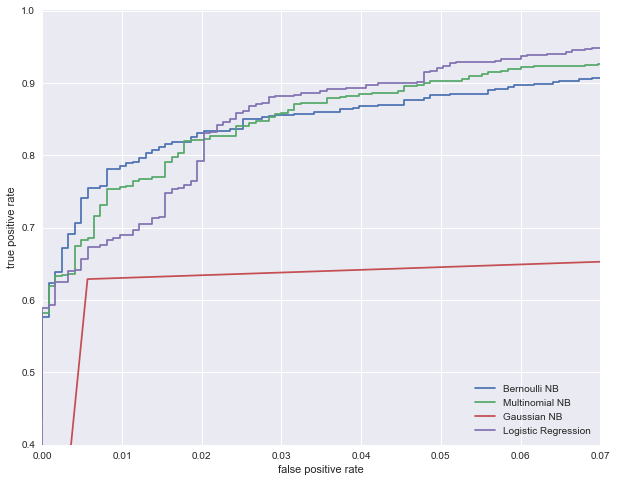

In [33]:

bern_fpr, bern_tpr, thresholds = build_curve(X_train_txt, X_test_txt, y_train, y_test, CountVectorizer(binary=True), BernoulliNB(), 0.01)

multi_fpr, multi_tpr, thresholds = build_curve(X_train_txt, X_test_txt, y_train, y_test, CountVectorizer(binary=False), MultinomialNB(), 0.01)

gauss_fpr, gauss_tpr, thresholds = build_curve(X_train_txt, X_test_txt, y_train, y_test, TfidfVectorizer(), GaussianNB(), 0.01)

lr_fpr, lr_tpr, thresholds = build_curve(X_train_txt, X_test_txt, y_train, y_test, TfidfVectorizer(), LogisticRegression(), 0.01)


plt.plot(bern_fpr, bern_tpr, label="Bernoulli NB")
plt.plot(multi_fpr, multi_tpr, label="Multinomial NB")
plt.plot(gauss_fpr, gauss_tpr, label="Gaussian NB")
plt.plot(lr_fpr, lr_tpr, label="Logistic Regression")

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="lower right")

plt.xlim([0, .07])
plt.ylim([.40, 1.001])

plt.show()